Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


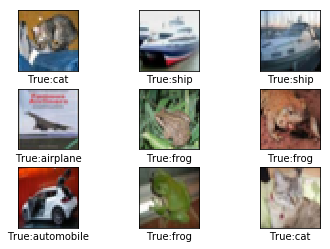

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
import math
import prettytensor as pt

import master.cifar10 as cifar10

cifar10.maybe_download_and_extract()

classes_name = cifar10.load_class_names()

classes_name

images_train,cls_train,labels_train = cifar10.load_training_data()

images_test, cls_test,labels_test = cifar10.load_test_data()

images_train.shape

# parameta
img_size = 32
img_chopped = 24
num_channels = 3
num_classes = len(classes_name)
logs = '/graph'
batch_size = 100
training_epoch = 32

def plot_images(images,cls_true,cls_pred = None, smooth = True):
    assert len(images) == len(cls_true) == 9
    
    fig,axes = plt.subplots(3,3)
    
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace = hspace, wspace = 0.3)
    
    for i,ax in enumerate(axes.flat):
        if smooth:
            interpolation ="spline16"
        else:
            interpolation ="nearest"
        
        ax.imshow(images[i,:,:,:], interpolation = interpolation)
        cls_true_name = classes_name[cls_true[i]]
        if cls_pred is None:
            xlabel = "True:{0}".format(cls_true_name)
        else:
            cls_pred_name = classes_name[cls_pred[i]]
            xlable = "True:{0}\nPred:{1}".format(cls_true_name,cls_pred_name)
        
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show() 

images = images_test[0:9]
cls_true = cls_test[0:9]
combined_size = len(images_train)
combined_size

plot_images(images,cls_true, smooth = False)

def shuffle_data():
    idx = np.random.permutation(combined_size)
    
    train_xs = images_train[idx]
    train_ys = labels_train[idx]
    train_cls =cls_train[idx]
    
    return train_xs,train_ys,train_cls

idx = np.random.permutation(combined_size)

def pre_processing_image(image):
    image = tf.random_crop(image, size = [img_chopped, img_chopped,num_channels])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image,max_delta = 0.5)
    image = tf.image.random_contrast(image,lower =0.3, upper = 1.0)
    image = tf.image.random_brightness(image, max_delta =0.2)
    image = tf.image.random_saturation(image,lower = 0.0,upper = 2.0)
    image = tf.minimum(image,1.0)
    image = tf.maximum(image,0.0)  
    return image

def pre_process(images):
    images = tf.map_fn(lambda image: pre_processing_image(image),images)
    return(images)
    
def pre_processing_image_test(image):
    image = tf.image.resize_image_with_chop_or_pad(image, target_height =img_chopped,target_width = img_chopped)
    return image

def pre_process_test(images):
    images = tf.map_fn(lambda image: pre_processing_image_tets(image), images)
    return images

class Model:
    def __init__(self,sess,name):
        self.sess = sess
        self.name = name
        self.build_net()
        
    def build_net(self):
        self.Y = tf.placeholder(tf.float32, shape = [None,num_classes])
        self.X_img = tf.placeholder(tf.float32, shape = [None,img_chopped,img_chopped,num_channels])
        self.Pretty_X = pt.wrap(self.X_img)
        
        with pt.defaults_scope(activation_fn = tf.nn.relu):
            self.hypothesis,self.cost = self.Pretty_X.\
                conv2d(kernel = 3, depth = 32, name = "convol_1",batch_normalize=True ).\
                max_pool(kernel = 2, stride = 2).\
                conv2d(kernel = 3, depth = 64, name = "convol_2").\
                max_pool(kernel = 3, stride = 2).\
                conv2d(kernel = 5, depth = 128, name = "convol_3").\
                max_pool(kernel = 2, stride =2 ).\
                flatten().\
                fully_connected(size = 512, name ="fully_1").\
                fully_connected(size = 256, name = "fully_2").\
                fully_connected(size = 128, name = "fully_3").\
                fully_connected(size = num_classes, name = "fully_4").\
                softmax_classifier(num_classes = num_classes, labels = self.Y)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate = 0.05).minimize(self.cost)
        self.is_correct = tf.equal(tf.argmax(self.hypothesis,1),tf.argmax(self.Y,1))
        self.Accuracy = tf.reduce_mean(tf.cast(self.is_correct, dtype = tf.float32))
    
    def train(self,train_data_xs,train_data_ys):
        return self.sess.run([self.cost,self.optimizer], feed_dict = {self.X_img:train_data_xs, self.Y:train_data_ys})
    
    def predict(self,test_xs):
        return self.sess.run([self.hypothesis], feed_dict = {self.X_img:test_xs})
    
    def Accuracy1(self,test_xs1,test_ys1):
        return self.sess.run([self.Accuracy], feed_dict = {self.X_img:test_xs1, self.Y:test_ys1})


In [2]:
sess = tf.Session()
model_saver = []
num_model = 4
for m in range(num_model):
    model_saver.append(Model(sess,"Model"+str(m)))
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [ ]:

# training
print("Learning started")
print("--------------------------------------------------------------")
for num_ensemble,worker in enumerate(model_saver):
    print("Ensemble:", num_ensemble)
    shuffled_img,shuffled_labels,shuffled_cls = shuffle_data()
    pre_processing_img = pre_process(shuffled_img)
    pre_processing_img = sess.run(pre_processing_img)
    for epoch in range(training_epoch):
        cost_val = 0
        total_batch = int(combined_size/ batch_size)
        for b in range(total_batch):
            batch_xs = pre_processing_img[100*b:100*b+100]
            batch_ys = shuffled_labels[100*b:100*b+100]
            c, _ =worker.train(batch_xs,batch_ys)
            cost_val +=c/total_batch
        if epoch % 1 ==0:
            print("Epoch:", epoch,"cost_val:", cost_val)
    print("----------------------------------------------------------")
print("learning_finished")
print("----------------------------------------------------")

Learning started
--------------------------------------------------------------
Ensemble: 0
